# Variable Bathymetry

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from Snoopy.WaveKinematic import VariableBathymetry

VariableBathymetry Object is defined with the following parameters:

- $x_0$: x-coordinate for the bathymetry variation start.
- $xmax$: x-coordinate for the bathymetry variation end.
- $depthFunc$: function describing the bathymetry variation with x (h = f(x)) (should be vectorized)
- $x$ : x locations for variable bathymetry, should be defined if x0, xmax and depthFunc are None
- $depth$ : corresponding depths at x locations for variable bathymetry, should be defined if x0, xmax and depthFunc are None
- $wrps$: frequency vector
- $wdiff$: difference frequency vector
- $heading$: heading vector in degree.
- $nstep$ : number of steps for discretization (optional, default is 100)
- $refWave$: incident wave reference point. (optional, the default is [0.,0.])


## Inputs

The following example is taken from "Experimental and numerical study of the effect of variable bathymetry on the slow-drift wave response of floating bodies" (Lui et al.,  Applied Ocean Research 2011).

In [2]:
x0 = 0.0
h0 = 1.05

# bathymetry slope
slope = 5/100
depthFunc = lambda x : -slope*(x-x0) + h0

hmax = 0.15
xmax = (h0-hmax)/slope + x0

# frequencies and headings
wmin = 2.
wmax = 9.
nw = 40
wrps = np.linspace(wmin,wmax,nw)

Tr = 10.0
wdiff  = np.array([2.*np.pi/Tr]) 
heading = [0.0,30.]


### Definition of bathymetry using a function (depthFunc)

In [3]:
bathymetry = VariableBathymetry(x0=x0, xmax=xmax, 
                                depthFunc = depthFunc,
                                wrps = wrps, wdiff= wdiff,
                                heading=heading)
print(bathymetry.wrps)

[2.         2.17948718 2.35897436 2.53846154 2.71794872 2.8974359
 3.07692308 3.25641026 3.43589744 3.61538462 3.79487179 3.97435897
 4.15384615 4.33333333 4.51282051 4.69230769 4.87179487 5.05128205
 5.23076923 5.41025641 5.58974359 5.76923077 5.94871795 6.12820513
 6.30769231 6.48717949 6.66666667 6.84615385 7.02564103 7.20512821
 7.38461538 7.56410256 7.74358974 7.92307692 8.1025641  8.28205128
 8.46153846 8.64102564 8.82051282 9.        ]


### Definition using  discrete points

In [4]:
x = np.array([x0,xmax])
h1 = depthFunc(xmax)
depth = np.array([h0,h1])

bathymetry_d = VariableBathymetry(x = x,
                                  depth = depth,
                                  wrps = wrps, wdiff= wdiff,
                                  heading=heading)

### Plot bathymetry profile

The bathymetry profil can be plotted for a given x vector, if x is not defined it will plot the bathymetry over the mesh points  

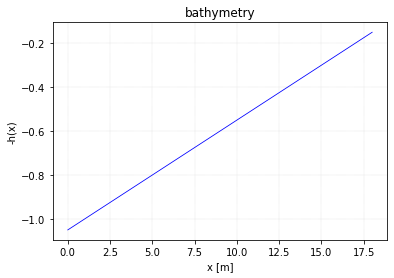

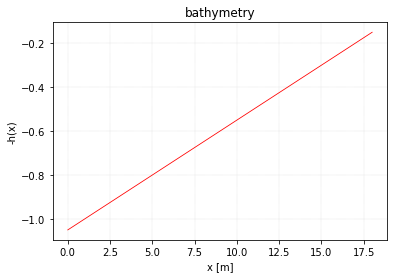

In [5]:
# depthfunc
fig,ax = plt.subplots()
ax = bathymetry.plot_bathymetry(ax,color='b')
# discrete points
fig,ax = plt.subplots()
ax = bathymetry_d.plot_bathymetry(ax,color='r')

By default, if $x$ > $xmax$ or $x$<$x0$ the bathyemtry is extrapolated with constant depth

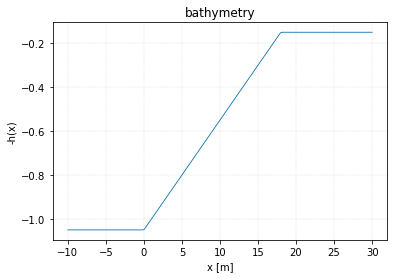

In [6]:
x  = np.linspace(-10,30,200)
ax = bathymetry.plot_bathymetry(x = x)

## First-order wave kinematics

First order wave kineamatics such as wave amplitude, wave-number, etc can be evaluated for a varying bathymertry at different x locations.
if x is not defined, it will evalute wave kineamatics on mesh points

In [7]:
results = bathymetry.first_order_kinematics(x)

The results are stored in a dict:

In [8]:
results.keys()

dict_keys(['depth', 'wave_number', 'x-wave_number', 'group_velocity', 'amplitude'])

We can plot the wave amplitude over the variable bathymetry as follow (see the docstring for vector shape):

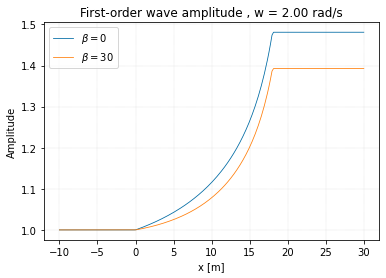

In [9]:
ifrq = 0
fig,ax = plt.subplots()
ax.plot(x,results['amplitude'][ifrq,0,:],label=r'$\beta=0$')
ax.plot(x,results['amplitude'][ifrq,1,:],label=r'$\beta=30$')
ax.set(xlabel='x [m]', ylabel='Amplitude')
ax.legend()
ax.set_title(f'First-order wave amplitude , w = {bathymetry.wrps[ifrq]:.2f} rad/s');

## Second-order wave kinematics

The second-order problem is solved as follow:

In [10]:
 bathymetry.solve_first_order_problem()

INFO    -       - SOLVE FIRST-ORDER PROBLEM  
INFO    -       - ---------------------------------------------------  
INFO    -       - > Compute first order wave kinematics for the first wave (w1)  
INFO    -       - > Compute first order wave kinematics for the second wave (w2)  
INFO    -       - ---------------------------------------------------
  


In [11]:
bathymetry.solve_second_order_problem()

INFO    -       - SOLVE SECOND-ORDER PROBLEM  
INFO    -       - ---------------------------------------------------  
INFO    -       - > Compute integration constants for particular part  
INFO    -       - Done  
INFO    -       - > Compute integration constants for homogeneous part  
INFO    -       - Done  
INFO    -       - ---------------------------------------------------
  


You can get the second-order potential on mesh points:

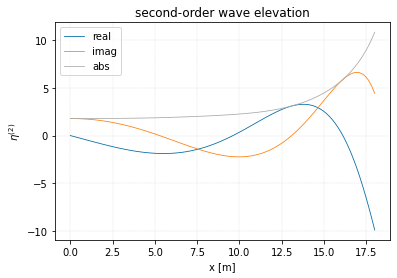

In [12]:
# wave amplitude
A1 = 1.0
A2 = 0.5
# heading index : 1st heading 0°
ib = 0
p = bathymetry.get_second_order_potential_mesh()[0,0,ib,:]    
elv = A1*A2*p / bathymetry._grav 

fig,ax = plt.subplots()
ax.plot(bathymetry._x, elv.real, label='real')
ax.plot(bathymetry._x, elv.imag,label='imag')
ax.plot(bathymetry._x, np.abs(elv),label='abs')
ax.legend()
ax.grid(True)
ax.set_xlabel('x [m]')
ax.set_ylabel(r'$\eta^{(2)}$')
ax.set_title('second-order wave elevation');

Or by specifying the point coordinates:

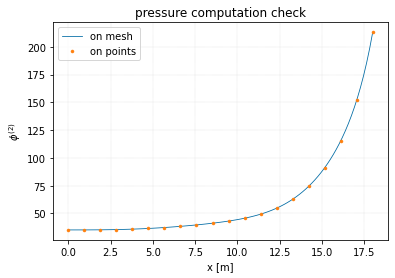

In [13]:
npt = 20
zs  = -0.0
points = np.zeros( (npt,3) )
points[:,0] = np.linspace(x0,xmax,npt)
points[:,2] = zs
p1 = bathymetry.get_second_order_potential(points)[0,0,ib,:] 

fig,ax = plt.subplots()
ax.plot(bathymetry._x, np.abs(p), label='on mesh')
ax.plot(points[:,0], np.abs(p1), marker='.', linestyle='', label='on points')
ax.legend()
ax.grid(True)
ax.set_xlabel('x [m]')
ax.set_ylabel(r'$\phi^{(2)}$')
ax.set_title('pressure computation check');    

## Correction factor R and alpha

The correction factor R and angle alpha can be evaluated on specific points as follow:

In [14]:
from scipy.optimize import fsolve

# get the x locations 
depths = np.array([21.,29.,40.]) / 100.
x_locations = [ fsolve( func = lambda x: depthFunc(x) - h, x0=0 )[0]   for h in depths ]

points = np.array( [  [x,0,0]  for x in x_locations ] )
npt = points.shape[0]

In [15]:
R, alpha = bathymetry.get_correction_factor(points,phase_degree = True)

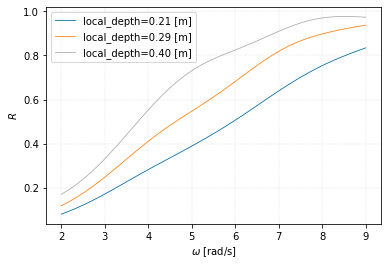

In [16]:
# plot R for heading 0°
ib = 0
fig,ax = plt.subplots()
for ipt in range(npt):
    ax.plot(bathymetry.wrps,R[:,:,ib,ipt].reshape(-1),label=f'local_depth={depths[ipt]:.2f} [m]')

ax.set_xlabel(r'$\omega$ [rad/s]')
ax.set_ylabel(r'$R$')
ax.grid(True)
ax.legend();

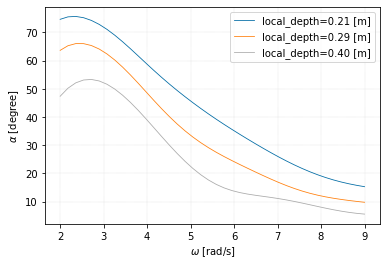

In [17]:
# plot alpha
fig,ax = plt.subplots()
for ipt in range(npt):
    ax.plot(bathymetry.wrps,alpha[:,:,ib,ipt].reshape(-1),label=f'local_depth={depths[ipt]:.2f} [m]')

ax.set_ylabel(r'$\alpha$ [degree]')
#ax.set_ylim(0,80)
ax.grid(True)
ax.set_xlabel(r'$\omega$ [rad/s]')
#ax.set_xlim(wmin,wmax)
ax.legend();